# Testing DEMV on _Communities&Crime_ (CRIME) dataset

Data source: [https://archive.ics.uci.edu/ml/datasets/communities+and+crime](https://archive.ics.uci.edu/ml/datasets/communities+and+crime)

- Unprivileged group: `black_people=1`
- Positive label: 100

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss

import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
from demv import DEMV

sns.set_style('whitegrid')

In [2]:
def prepare_data():
  '''Load the data and apply some pre-processing steps'''
  
  data = pd.read_excel('data/crime_data_normalized.xlsx', na_values='?')
  data.drop(['state', 'county', 'community', 'communityname',
            'fold', 'OtherPerCap'], axis=1, inplace=True)
  na_cols = data.isna().any()[data.isna().any() == True].index
  data.drop(na_cols, axis=1, inplace=True)
  data = (data - data.mean())/data.std()
  y_classes = np.quantile(data['ViolentCrimesPerPop'].values, [
                          0, 0.2, 0.4, 0.6, 0.8, 1])
  i = 0
  data['ViolentCrimesClass'] = data['ViolentCrimesPerPop']
  for cl in y_classes:
    data.loc[data['ViolentCrimesClass'] <= cl, 'ViolentCrimesClass'] = i*100
    i += 1
  data.drop('ViolentCrimesPerPop', axis=1, inplace=True)
  data['black_people'] = data['racepctblack'] > -0.45
  data['hisp_people'] = data['racePctHisp'] > -0.4
  data['black_people'] = data['black_people'].astype(int)
  data['hisp_people'] = data['hisp_people'].astype(int)
  data.drop('racepctblack', axis=1, inplace=True)
  data.drop('racePctHisp', axis=1, inplace=True)
  return data


In [3]:
def plot_group_percentage(data, protected_vars: list, label_name, label_value):
    full_list = protected_vars.copy()
    full_list.append(label_name)
    perc = (data[full_list]
            .groupby(protected_vars)[label_name]
            .value_counts(normalize=True)
            .mul(100).rename('Percentage')
            .reset_index()
            )
    perc['Groups'] = perc[protected_vars].apply(
        lambda x: '('+','.join(x.astype(str))+')', axis=1)
    sns.barplot(data=perc[perc[label_name]
                == label_value], x='Groups', y='Percentage')
    plt.title('Percentage distribution of label for each sensitive group')
    plt.show()


In [4]:
data = prepare_data()

/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [5]:
label = 'ViolentCrimesClass'
groups_condition = {'black_people': 1}
sensitive_features = ['black_people']
positive_label = 100

In [6]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(n_jobs=-1))
])

## Logistic Regression Bias

In [7]:
model, lr_bias = cross_val(pipeline, data, label, groups_condition, sensitive_features, positive_label=positive_label)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [8]:
print_metrics(lr_bias)

Statistical parity:  -0.44  +-  0.076
Disparate impact:  0.135  +-  0.064
Zero one loss:  0.058  +-  0.048
F1 score:  0.487  +-  0.03
Accuracy score:  0.497  +-  0.027


## DEMV application

In [9]:
demv = DEMV(round_level=1)
demv_data = data.copy()

### Logistic regression DEMV

In [10]:
model, lr_demv = cross_val(pipeline, demv_data, label, groups_condition, sensitive_features, debiaser=demv, positive_label=100)
print_metrics(lr_demv)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Statistical parity:  -0.281  +-  0.076
Disparate impact:  0.344  +-  0.135
Zero one loss:  0.057  +-  0.048
F1 score:  0.448  +-  0.036
Accuracy score:  0.457  +-  0.033


In [11]:
print_metrics(lr_demv)

Statistical parity:  -0.281  +-  0.076
Disparate impact:  0.344  +-  0.135
Zero one loss:  0.057  +-  0.048
F1 score:  0.448  +-  0.036
Accuracy score:  0.457  +-  0.033


## Exponentiated Gradient

In [12]:
fl_data = data.copy()

### Logistic Regression

In [13]:
const = BoundedGroupLoss(ZeroOneLoss(), upper_bound=0.5)
l_model = ExponentiatedGradient(pipeline, const, sample_weight_name="classifier__sample_weight")


In [14]:
l_model, exp_metrics = cross_val(l_model, fl_data, label, groups_condition, sensitive_features, exp=True, positive_label=100)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [15]:
print_metrics(exp_metrics)

Statistical parity:  -0.442  +-  0.079
Disparate impact:  0.13  +-  0.067
Zero one loss:  0.056  +-  0.048
F1 score:  0.487  +-  0.032
Accuracy score:  0.497  +-  0.028


## DEMV Evaluation

In [16]:
demv.get_iters()

131

In [17]:
metrics = eval_demv(60, 200, data.copy(), pipeline, label, groups_condition, sensitive_features, positive_label=100)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [21]:
df = pd.DataFrame(metrics)

In [22]:
df = prepareplots(metrics,'crimeSinglevar')
iters = df['stop'].iloc[-1]

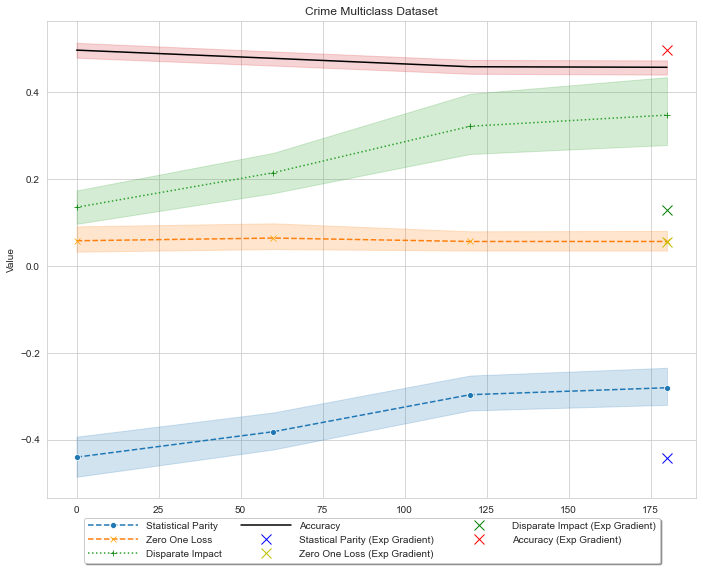

In [23]:
points = preparepoints(exp_metrics, iters)

plot_metrics_curves(df, points, title='Crime Multiclass Dataset')
